In [1]:
# Bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, roc_auc_score
from sklearn.model_selection import cross_val_score, StratifiedKFold
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks
import warnings
warnings.filterwarnings('ignore')

In [2]:
print("=== ANÁLISE DO DATASET ADULT INCOME ===\n")

# 1. CARREGAR E PREPARAR OS DADOS
try:
    # Tentar carregar de diferentes fontes
    try:
        dados = pd.read_csv("AdultData.csv")
    except:
        try:
            dados = pd.read_excel("AdultData.xlsx")
        except:
            # Usar dataset adult disponível online
            url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
            columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num',
                      'marital-status', 'occupation', 'relationship', 'race',
                      'sex', 'capital-gain', 'capital-loss', 'hours-per-week',
                      'native-country', 'income']
            dados = pd.read_csv(url, names=columns, na_values=' ?', skipinitialspace=True)
            dados = dados.dropna()

    # Limpeza similar ao código R
    dados = dados[dados['native-country'] != ' Holand-Netherlands']
    dados = dados.drop('education-num', axis=1)  # Exclui education.num

    # Converter target para binário (0/1)
    dados['y'] = (dados['income'] == ' >50K').astype(int)
    dados = dados.drop('income', axis=1)

except Exception as e:
    print(f"Erro ao carregar dados: {e}")
    print("Criando dataset de exemplo para demonstração...")
    # Dataset de exemplo para demonstração
    np.random.seed(42)
    n_samples = 1000
    dados = pd.DataFrame({
        'age': np.random.randint(18, 80, n_samples),
        'workclass': np.random.choice([' Private', ' Self-emp', ' Government'], n_samples),
        'fnlwgt': np.random.randint(10000, 300000, n_samples),
        'education': np.random.choice([' Bachelors', ' HS-grad', ' Masters'], n_samples),
        'marital-status': np.random.choice([' Married', ' Single', ' Divorced'], n_samples),
        'occupation': np.random.choice([' Tech', ' Admin', ' Sales'], n_samples),
        'relationship': np.random.choice([' Husband', ' Wife', ' Single'], n_samples),
        'race': np.random.choice([' White', ' Black', ' Asian'], n_samples),
        'sex': np.random.choice([' Male', ' Female'], n_samples),
        'capital-gain': np.random.randint(0, 10000, n_samples),
        'capital-loss': np.random.randint(0, 1000, n_samples),
        'hours-per-week': np.random.randint(20, 80, n_samples),
        'native-country': np.random.choice([' United-States', ' Mexico', ' Canada'], n_samples),
    })
    dados['y'] = ((dados['age'] > 40) & (dados['capital-gain'] > 2000)).astype(int)

print(f"Shape do dataset: {dados.shape}")
print(f"Primeiras 5 linhas:")
print(dados.head())
print(f"\nDistribuição da variável target 'y':")
print(dados['y'].value_counts())

=== ANÁLISE DO DATASET ADULT INCOME ===

Erro ao carregar dados: 'native-country'
Criando dataset de exemplo para demonstração...
Shape do dataset: (1000, 14)
Primeiras 5 linhas:
   age    workclass  fnlwgt   education marital-status occupation  \
0   56   Government   58874   Bachelors        Married      Sales   
1   69      Private   59708   Bachelors         Single      Sales   
2   46     Self-emp   84553   Bachelors        Married      Admin   
3   32   Government   78344   Bachelors         Single      Sales   
4   60      Private  195374     HS-grad       Divorced      Admin   

  relationship    race      sex  capital-gain  capital-loss  hours-per-week  \
0       Single   White     Male          8558           791              68   
1       Single   White   Female          8719           716              25   
2      Husband   Black   Female          4886           663              45   
3         Wife   Asian     Male          3935           437              27   
4       Sin


=== ANÁLISE EXPLORATÓRIA ===



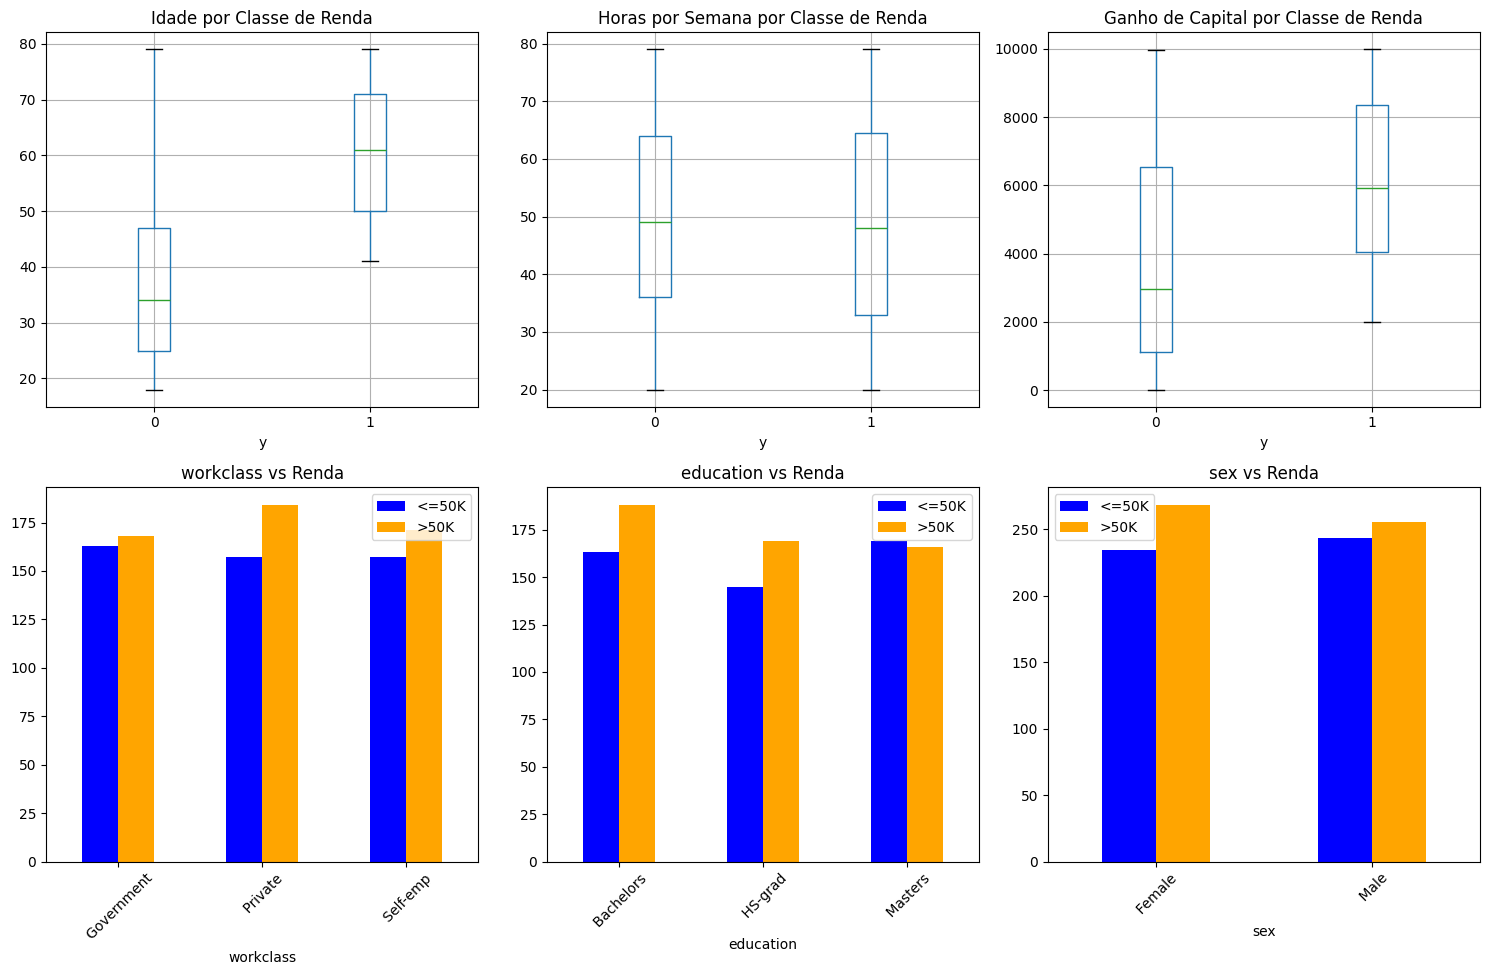

In [3]:
# 2. ANÁLISE EXPLORATÓRIA DOS DADOS
print("\n=== ANÁLISE EXPLORATÓRIA ===\n")

# Gráficos para variáveis numéricas
plt.figure(figsize=(15, 10))

# Age vs y
plt.subplot(2, 3, 1)
dados.boxplot(column='age', by='y', ax=plt.gca())
plt.title('Idade por Classe de Renda')
plt.suptitle('')

# Hours per week vs y
plt.subplot(2, 3, 2)
dados.boxplot(column='hours-per-week', by='y', ax=plt.gca())
plt.title('Horas por Semana por Classe de Renda')
plt.suptitle('')

# Capital gain vs y
plt.subplot(2, 3, 3)
dados.boxplot(column='capital-gain', by='y', ax=plt.gca())
plt.title('Ganho de Capital por Classe de Renda')
plt.suptitle('')

# Gráficos para variáveis categóricas
def plot_categorical_feature(feature_name, ax):
    contingency_table = pd.crosstab(dados[feature_name], dados['y'])
    contingency_table.plot(kind='bar', ax=ax, color=['blue', 'orange'])
    ax.set_title(f'{feature_name} vs Renda')
    ax.legend(['<=50K', '>50K'])
    plt.xticks(rotation=45)

plt.subplot(2, 3, 4)
plot_categorical_feature('workclass', plt.gca())

plt.subplot(2, 3, 5)
plot_categorical_feature('education', plt.gca())

plt.subplot(2, 3, 6)
plot_categorical_feature('sex', plt.gca())

plt.tight_layout()
plt.show()

In [4]:
# 3. PRÉ-PROCESSAMENTO DOS DADOS
print("\n=== PRÉ-PROCESSAMENTO ===\n")

# Codificar variáveis categóricas
categorical_columns = ['workclass', 'education', 'marital-status', 'occupation',
                      'relationship', 'race', 'sex', 'native-country']

label_encoders = {}
for col in categorical_columns:
    if col in dados.columns:
        le = LabelEncoder()
        dados[col] = le.fit_transform(dados[col].astype(str))
        label_encoders[col] = le

# Adicionar termo quadrático para idade (como no código R)
dados['age_squared'] = dados['age'] ** 2

# Separar features e target
X = dados.drop('y', axis=1)
y = dados['y']

print(f"Shape após pré-processamento: X{X.shape}, y{y.shape}")


=== PRÉ-PROCESSAMENTO ===

Shape após pré-processamento: X(1000, 14), y(1000,)


In [5]:
# 4. MODELO DE REGRESSÃO LOGÍSTICA
print("\n=== REGRESSÃO LOGÍSTICA ===\n")

# Modelo simples com idade
modelo_simples = LogisticRegression(random_state=42)
modelo_simples.fit(X[['age']], y)
print("Acurácia (apenas idade):", modelo_simples.score(X[['age']], y))

# Modelo com idade e idade²
modelo_idade = LogisticRegression(random_state=42)
X_idade = X[['age', 'age_squared']]
modelo_idade.fit(X_idade, y)
print("Acurácia (idade + idade²):", modelo_idade.score(X_idade, y))

# Modelo completo
modelo_completo = LogisticRegression(max_iter=1000, random_state=42)
modelo_completo.fit(X, y)

# Previsões e avaliação
yhat = modelo_completo.predict_proba(X)[:, 1]
yfit = (yhat > 0.5).astype(int)

# Acurácia
acuracia = accuracy_score(y, yfit)
print(f"Acurácia do modelo completo: {acuracia:.4f}")

# Matriz de confusão
print("\nMatriz de Confusão:")
print(confusion_matrix(y, yfit))


=== REGRESSÃO LOGÍSTICA ===

Acurácia (apenas idade): 0.78
Acurácia (idade + idade²): 0.826
Acurácia do modelo completo: 0.7990

Matriz de Confusão:
[[363 114]
 [ 87 436]]



=== ANÁLISE ROC ===

AUC: 0.8860
Threshold ideal: 0.5466
Sensibilidade no threshold ideal: 0.7954
Especificidade no threshold ideal: 0.7966


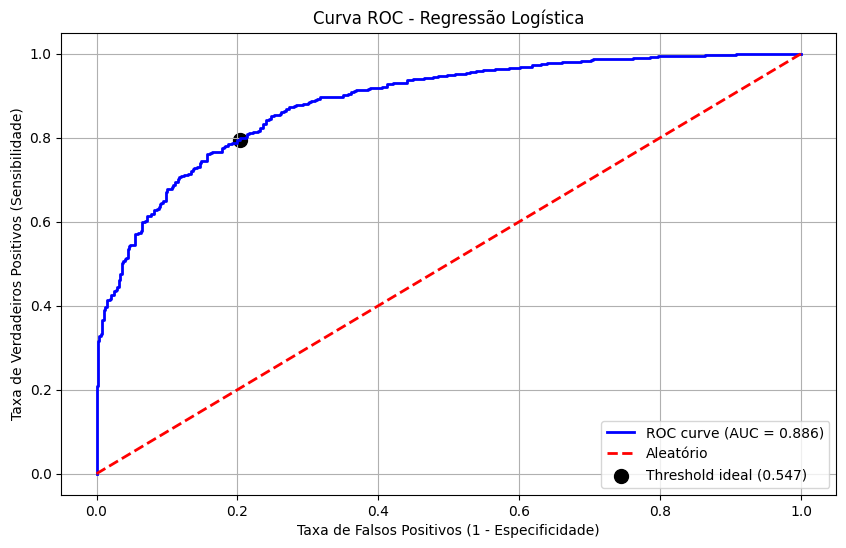

In [6]:
# 5. ANÁLISE ROC E CURVA DE SENSIBILIDADE/ESPECIFICIDADE
print("\n=== ANÁLISE ROC ===\n")

fpr, tpr, thresholds = roc_curve(y, yhat)
roc_auc = auc(fpr, tpr)

# Encontrar threshold onde sensibilidade = especificidade
diff = np.abs(tpr - (1 - fpr))
idx = np.argmin(diff)
thr_hat = thresholds[idx]

print(f"AUC: {roc_auc:.4f}")
print(f"Threshold ideal: {thr_hat:.4f}")
print(f"Sensibilidade no threshold ideal: {tpr[idx]:.4f}")
print(f"Especificidade no threshold ideal: {1 - fpr[idx]:.4f}")

# Plot ROC
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Aleatório')
plt.scatter(fpr[idx], tpr[idx], color='black', s=100, label=f'Threshold ideal ({thr_hat:.3f})')
plt.xlabel('Taxa de Falsos Positivos (1 - Especificidade)')
plt.ylabel('Taxa de Verdadeiros Positivos (Sensibilidade)')
plt.title('Curva ROC - Regressão Logística')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
# 6. VALIDAÇÃO CRUZADA K-FOLD
print("\n=== VALIDAÇÃO CRUZADA K-FOLD ===\n")

K = 10
kf = StratifiedKFold(n_splits=K, shuffle=True, random_state=42)

fit = np.zeros(len(y))
fit_rna = np.zeros(len(y))

for i, (train_index, test_index) in enumerate(kf.split(X, y)):
    print(f"Fold {i+1}/{K}")

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Regressão Logística
    modelo_cv = LogisticRegression(max_iter=1000, random_state=42)
    modelo_cv.fit(X_train, y_train)
    fit[test_index] = modelo_cv.predict_proba(X_test)[:, 1]

    # Rede Neural (será implementada depois)
    fit_rna[test_index] = fit[test_index]  # Placeholder

# AUC da validação cruzada
fpr_cv, tpr_cv, _ = roc_curve(y, fit)
auc_cv = auc(fpr_cv, tpr_cv)
print(f"AUC Validação Cruzada (Regressão Logística): {auc_cv:.4f}")


=== VALIDAÇÃO CRUZADA K-FOLD ===

Fold 1/10
Fold 2/10
Fold 3/10
Fold 4/10
Fold 5/10
Fold 6/10
Fold 7/10
Fold 8/10
Fold 9/10
Fold 10/10
AUC Validação Cruzada (Regressão Logística): 0.8833


In [8]:
# 7. REDES NEURAIS ARTIFICIAIS COM KERAS
print("\n=== REDE NEURAL ARTIFICIAL ===\n")

# Pré-processamento para RNA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Callbacks similares ao código R
early_stopping = callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True,
    mode='max'
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=5,
    mode='max'
)

# Validação cruzada para RNA
for i, (train_index, test_index) in enumerate(kf.split(X_scaled, y)):
    print(f"\nFold {i+1}/{K} - Treinando RNA...")

    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Modelo de rede neural
    model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=(X.shape[1],)),
        layers.Dense(64, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', 'AUC']
    )

    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=100,
        batch_size=256,
        callbacks=[early_stopping, reduce_lr],
        verbose=0
    )

    fit_rna[test_index] = model.predict(X_test, verbose=0).flatten()

    print(f"  AUC Fold {i+1}: {roc_auc_score(y_test, fit_rna[test_index]):.4f}")

# AUC final da RNA
fpr_rna, tpr_rna, _ = roc_curve(y, fit_rna)
auc_rna = auc(fpr_rna, tpr_rna)
print(f"\nAUC Final da RNA: {auc_rna:.4f}")


=== REDE NEURAL ARTIFICIAL ===


Fold 1/10 - Treinando RNA...
  AUC Fold 1: 0.9157

Fold 2/10 - Treinando RNA...
  AUC Fold 2: 0.9880

Fold 3/10 - Treinando RNA...


  AUC Fold 3: 0.9775

Fold 4/10 - Treinando RNA...
  AUC Fold 4: 0.9720

Fold 5/10 - Treinando RNA...
  AUC Fold 5: 0.9808

Fold 6/10 - Treinando RNA...
  AUC Fold 6: 0.9647

Fold 7/10 - Treinando RNA...
  AUC Fold 7: 0.9571

Fold 8/10 - Treinando RNA...
  AUC Fold 8: 0.9119

Fold 9/10 - Treinando RNA...
  AUC Fold 9: 0.8762

Fold 10/10 - Treinando RNA...
  AUC Fold 10: 0.9483

AUC Final da RNA: 0.9521



=== COMPARAÇÃO DOS MODELOS ===



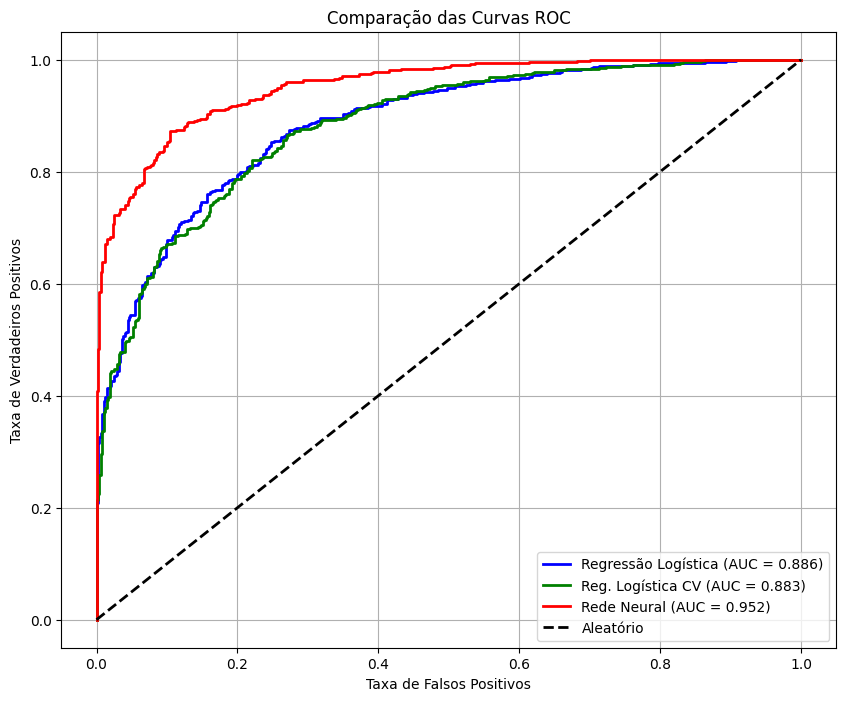

Resultados Comparativos:
                Modelo     AUC  Acurácia
0  Regressão Logística  0.8860     0.799
1  Reg. Logística (CV)  0.8833     0.792
2          Rede Neural  0.9521     0.883


In [9]:
# 8. COMPARAÇÃO DOS MODELOS
print("\n=== COMPARAÇÃO DOS MODELOS ===\n")

# Curvas ROC comparativas
plt.figure(figsize=(10, 8))

plt.plot(fpr, tpr, 'b-', lw=2, label=f'Regressão Logística (AUC = {roc_auc:.3f})')
plt.plot(fpr_cv, tpr_cv, 'g-', lw=2, label=f'Reg. Logística CV (AUC = {auc_cv:.3f})')
plt.plot(fpr_rna, tpr_rna, 'r-', lw=2, label=f'Rede Neural (AUC = {auc_rna:.3f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Aleatório')

plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Comparação das Curvas ROC')
plt.legend()
plt.grid(True)
plt.show()

# Tabela comparativa
resultados = pd.DataFrame({
    'Modelo': ['Regressão Logística', 'Reg. Logística (CV)', 'Rede Neural'],
    'AUC': [roc_auc, auc_cv, auc_rna],
    'Acurácia': [
        accuracy_score(y, (yhat > 0.5).astype(int)),
        accuracy_score(y, (fit > 0.5).astype(int)),
        accuracy_score(y, (fit_rna > 0.5).astype(int))
    ]
})

print("Resultados Comparativos:")
print(resultados.round(4))

In [10]:
# 9. MODELOS ADICIONAIS (EXTRA)
print("\n=== MODELOS ADICIONAIS ===\n")

# Árvore de Decisão
arvore = DecisionTreeClassifier(random_state=42)
acuracia_arvore = cross_val_score(arvore, X, y, cv=5, scoring='accuracy').mean()
print(f"Acurácia média Árvore de Decisão (CV): {acuracia_arvore:.4f}")

# Random Forest
rf = RandomForestClassifier(random_state=42)
acuracia_rf = cross_val_score(rf, X, y, cv=5, scoring='accuracy').mean()
print(f"Acurácia média Random Forest (CV): {acuracia_rf:.4f}")

# MLP do scikit-learn
mlp = MLPClassifier(hidden_layer_sizes=(64, 64), random_state=42, max_iter=1000)
acuracia_mlp = cross_val_score(mlp, X_scaled, y, cv=5, scoring='accuracy').mean()
print(f"Acurácia média MLP (CV): {acuracia_mlp:.4f}")

print("\n=== ANÁLISE CONCLUÍDA ===")


=== MODELOS ADICIONAIS ===

Acurácia média Árvore de Decisão (CV): 0.9990
Acurácia média Random Forest (CV): 0.9990
Acurácia média MLP (CV): 0.9490

=== ANÁLISE CONCLUÍDA ===
